## Import libraries

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyrolite.comp import pyrocomp
from sklearn.model_selection import train_test_split
import optuna
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from scipy.signal import savgol_filter
from lightgbm import LGBMRegressor
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost 

import sklearn.ensemble
import sklearn.model_selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
import pysptools.spectro as spectro

from concurrent.futures import ThreadPoolExecutor, as_completed
import random
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
warnings.filterwarnings("ignore", category=RuntimeWarning, module="your_module_or_function")
from sklearn.utils import resample


## Functions for hyperparameters optimization

In [11]:
optuna.logging.set_verbosity(optuna.logging.INFO)

# Define a custom scoring function using r2_score
def custom_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

def objective_rfr(trial):
    param = {
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 1.0),
    }

    regressor_obj = RandomForestRegressor(**param)
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_xgbr(trial):
        
    param = {
        'max_depth' : trial.suggest_int("max_depth", 3, 12),
        'gamma' : trial.suggest_float ("gamma", 0,5),
        'learning_rate' : trial.suggest_float ("eta", 0.01, 0.05),
        'subsample' : trial.suggest_float ("subsample", 0.5, 1),
        'colsample_bytree' : trial.suggest_float ("xgbr_colsample_bytree", 0.5, 1),
        'min_child_weight' : trial.suggest_int ("min_child_weight", 1, 10)
        }
    
    regressor_obj = xgboost.XGBRegressor(**param)  
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_lgbr(trial):
    
    param = {
        'metric': 'mae', 
        'random_state': 48,
        'n_estimators': trial.suggest_int ('n_estimators', 10, 15000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1000),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
    }
    regressor_obj = LGBMRegressor(**param)  
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_svr(trial):
    
    param = {
        'kernel': trial.suggest_categorical("kernel", ["linear", "rbf"]),
        'degree': trial.suggest_int ('degree', 1, 5),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1),
        'epsilon': trial.suggest_loguniform('epsilon', 1e-3, 0.1),
        'C': trial.suggest_float('C', 0.1, 2),
    }
    regressor_obj = SVR(**param)  
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_plsr(trial):
    
    param = {
        'n_components': trial.suggest_int ('n_components', 2, 8),
        'tol':trial.suggest_float ('tol', 1e-8, 1e-2),
        'scale':trial.suggest_categorical ('scale', [True, False])
    }
    regressor_obj = PLSRegression(**param)  
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()


## Import données
Ce jeu de données contient les données de bassin contenant : 
- intervalles de composites de géochimie
- spectres moyennés par intervalles de géochimie
- résistivité (RLLD) moyenné sur les mêmes intervalles
- les données censurées de géochimie ont été corrigées (cf article).

On essaie de prédire la résistivité à partir de la géochimie/spectral. On teste différents scénarios : 
- Random train-test split vs drillhole based train-test split (une prédiction robuste doit obtenir des résultats similaires sur les deux méthodes d'échantillonnage)
- Différents algos
- Différents scénarios (spectroscopie seule avec différents traitements,


In [4]:
data = pd.read_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Clean_Data\Logs_Basin.csv')

## add a filler variable
data.insert(data.columns.get_loc('Zr') + 1, 'Filler', 1000000 - data[data.loc[:, 'Ag':'Zr'].columns].sum(axis=1))

## remove invalid values
data.drop(data[data['LogRLLD'] < 0].index, inplace=True)

## Spectral trimming of 'noisiest' wavelengths
spectral = data.loc[:, '500':'2400']

## Continuum removal

In [5]:
## load already computed continuum removed spectra : 
wvl = np.arange(350, 2498, 1)

removed_spectra = np.load(r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Clean_Data\CR_Spectra.npy')
removed_spectra = pd.DataFrame (removed_spectra, columns = wvl)
data_cr = pd.concat ([data.loc[:, 'HoleName':'Filler'], removed_spectra], axis = 1, sort = False)


In [5]:
## Launch only to perform continuum removal from the original dataset, otherwise use only the snippet above (already computed CR)

spectral = data.loc[:, '350':'2498']

#wavelength array
wvl = np.arange(350, 2498, 1)

# Function to apply convex hull removal
def remove_convex_hull(spectrum):
    removed = spectro.convex_hull_removal(spectrum, wvl)
    return removed[0]

# apply the function to each row
with tqdm(total=len(data), desc="Processing Spectra") as pbar:
    removed_spectra = []
    for _, row in spectral.iterrows():
        removed_spectra.append(remove_convex_hull(row))
        pbar.update(1)
stock = np.array([removed_spectra])
removed_spectra = pd.DataFrame (removed_spectra, columns = wvl)

## dataframe with continuum removed spectra
data_cr = pd.concat ([data.loc[:, 'HoleName':'Filler'], removed_spectra], axis = 1, sort = False)



Processing Spectra:   1%|▌                                                           | 25/2682 [00:03<06:12,  7.13it/s]


KeyboardInterrupt: 

# Blind well test-train split

In [6]:
## Séparation d'un jeu de données externe (Getty Russell)
## data si on utilise les spectres bruts // data_cr si on utilise les spectres corrigés du continuum
data_ml = data.loc[data['Project'] != 'GET']
data_get = data.loc[data['Project'] == 'GET']

## Sélection de 25% des forages pour le train/test split
#holenames = data_ml['HoleName'].unique().tolist()
#num_elements_to_select = int(len(holenames) * 25 / 100)
#testing_holenames = random.sample(holenames, num_elements_to_select)
#training_holenames = [name for name in holenames if name not in testing_holenames]

## Pour reprendre le train-test split utilisé dans l'article, utiliser : 
testing_holenames = pd.read_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Train_Test_Split\Testing_HoleNames.csv').iloc[:, 1].tolist()
training_holenames = pd.read_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Train_Test_Split\Training_HoleNames.csv').iloc[:, 1].tolist()

testing_data = data_ml[data_ml['HoleName'].isin(testing_holenames)]

training_data = data_ml[data_ml['HoleName'].isin(training_holenames)]



# Pre-Processing

In [12]:
###
### TRAINING DATA
###

geochem_training = training_data.loc[:, 'Ag':'Filler']
ir_training = training_data.loc[:, '1000':'2400']
ir_training = pd.DataFrame(savgol_filter(ir_training, 25, polyorder = 2, deriv = 1))

#geochem_ilr_training = geochem_training.pyrocomp.ILR()
geochem_clr_training = geochem_training.pyrocomp.CLR()

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_training.columns for element2 in geochem_training.columns if element1 < element2]
geochem_pwlr_training = pd.DataFrame(index=geochem_training.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_training[element1] / geochem_training[element2])
    geochem_pwlr_training[log_ratio_column] = log_ratios

###
### TESTING DATA
###

geochem_testing = testing_data.loc[:, 'Ag':'Filler']
ir_testing = testing_data.loc[:, '1000':'2400']
ir_testing = pd.DataFrame(savgol_filter(ir_testing, 25, polyorder = 2, deriv = 1))

#geochem_ilr_testing = geochem_testing.pyrocomp.ILR()
geochem_clr_testing = geochem_testing.pyrocomp.CLR()

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_testing.columns for element2 in geochem_testing.columns if element1 < element2]
geochem_pwlr_testing = pd.DataFrame(index=geochem_testing.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_testing[element1] / geochem_testing[element2])
    geochem_pwlr_testing[log_ratio_column] = log_ratios


C:\Users\serdoun1\AppData\Local\Temp\ipykernel_63404\2371445891.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  geochem_pwlr_training[log_ratio_column] = log_ratios
C:\Users\serdoun1\AppData\Local\Temp\ipykernel_63404\2371445891.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  geochem_pwlr_training[log_ratio_column] = log_ratios
C:\Users\serdoun1\AppData\Local\Temp\ipykernel_63404\2371445891.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

## Choix du scénario

In [14]:
geochem_pwlr_training = geochem_pwlr_training.reset_index(drop=True)
geochem_clr_training = geochem_clr_training.reset_index(drop=True)

geochem_pwlr_testing = geochem_pwlr_testing.reset_index(drop=True)
geochem_clr_testing = geochem_clr_testing.reset_index(drop=True)

# Choisir un scénario de données d'entraînement : ir_training, geochem_pwlr_training,... ou bien concaténer plusieurs jeux de données pour l'entrainement
X_train = pd.concat([geochem_pwlr_training, ir_training], axis=1)
X_train = geochem_clr_training
X_train.columns = X_train.columns.astype(str)

y_train = (training_data['LogRLLD']) 

## Choisir le même jeu de données pour le jeu de données test
X_test = pd.concat([geochem_pwlr_testing, ir_testing], axis=1)
X_test = geochem_clr_testing
X_test.columns = X_test.columns.astype(str)


#X_test = geochem_pwlr_testing

y_test = (testing_data['LogRLLD'])


## Training

In [15]:

# models and their corresponding objective functions
models = [
    # ('PLSR', objective_plsr),
     ('LGBR', objective_lgbr),
   # ('ABR', objective_adaboost),
    # ('XGBR', objective_xgbr),
    # ('RFR', objective_rfr),
    # ('SVR', objective_svr)
]

best_trials = {}

n_jobs = 8  ## nombre de workers à utiliser
n_trials = 100

for model_name, objective_function in models:
    print(model_name)

    progress_bar = tqdm(total=n_trials, position=0, leave=True, desc=model_name,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    def objective_with_progress_bar(trial):
        result = objective_function(trial)
        progress_bar.update(1)
        return result

    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_progress_bar, n_trials=n_trials, n_jobs=n_jobs)
    best_trials[model_name] = study.best_trial
    optuna.logging.set_verbosity(optuna.logging.INFO)
    progress_bar.close()

# evaluation on test dataset using cv
def evaluate_model_cv(model, X_test, y_test, progress_bar=None):
    y_pred = cross_val_predict(model, X_test, y_test, cv=5)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    if progress_bar:
        progress_bar.update(1)

    return rmse, r2

# launch models and get R² + rmse on validation dataset
for model_name, trial in best_trials.items():
    print(model_name)

    progress_bar = tqdm(total=1, position=0, leave=True, desc=model_name,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    def evaluate_with_progress_bar(X_test, y_test):
        model = None

        if model_name == 'PLSR':
            model = PLSRegression(n_components=trial.params['n_components'])
        elif model_name == 'LGBR':
            model = LGBMRegressor(**trial.params)
        elif model_name == 'XGBR':
            model = xgboost.XGBRegressor(**trial.params)
        elif model_name == 'RFR':
            model = RandomForestRegressor(**trial.params)
        elif model_name == 'SVR':
            model = SVR(**trial.params)
        elif model_name == 'ABR':
            model = AdaBoostRegressor(**trial.params)

        model.fit(X_train, y_train)
        rmse, r2 = evaluate_model_cv(model, X_test, y_test, progress_bar)
        print(f"{model_name} - R²: {r2}, RMSE: {rmse}")

    evaluate_with_progress_bar(X_test, y_test)

    progress_bar.close()

LGBR


LGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00]


LGBR


LGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00]

LGBR - R²: 0.731635466138957, RMSE: 0.19182746650170027


## Prediction intervals

In [31]:
## Bootstrap resampling to estimate prediction intervals on the selected model

# train model
rerun_lbgm = LGBMRegressor (**best_trials['LGBR'].params)
print(rerun_lbgm)

y_bootstrap = []
# bootstrap predictions
accuracy = []
n_iterations = 100
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples = 800)
    rerun_lbgm.fit(X_bs,y_bs)
    # make predictions
    y_hat = rerun_lbgm.predict(X_test)
    print(i)
    y_bootstrap.append(y_hat)
    
    # evaluate model
    
y_boostrap = pd.DataFrame(np.vstack(y_bootstrap))

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.038706004311654905,
              max_depth=14, min_child_samples=28, n_estimators=12585,
              num_leaves=125, reg_alpha=0.07285877189674618,
              reg_lambda=0.004262478468969992)
0
1
2
3


KeyboardInterrupt: 

## Scatterplots prédictions

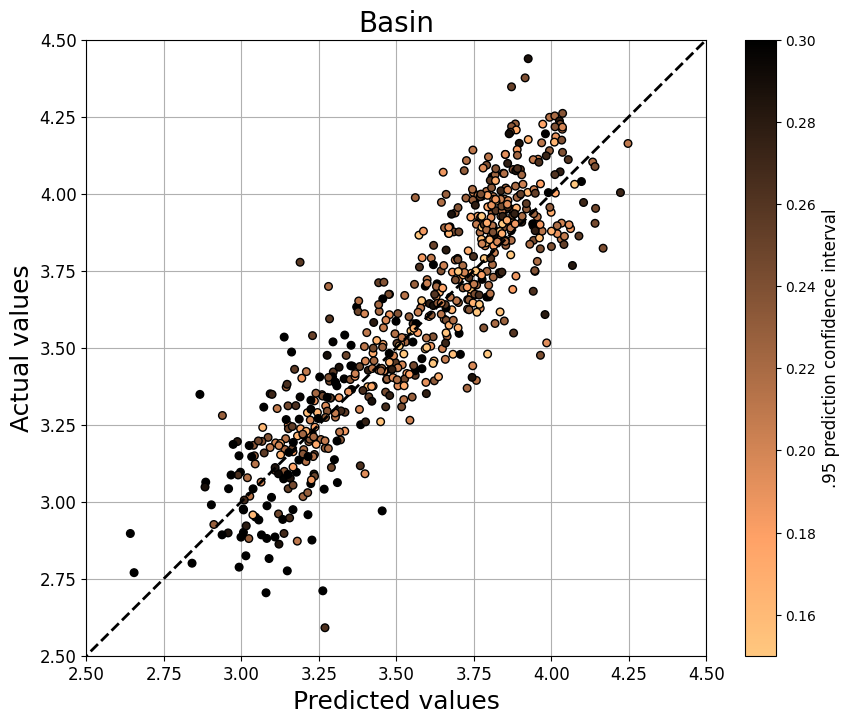

629


In [17]:
uncertainty = pd.DataFrame(y_bootstrap).std(axis = 0)
mean = pd.DataFrame(y_bootstrap).mean(axis = 0)
y_hat = rerun_lbgm.predict(X_test)
plt.rc('axes', axisbelow=True)

upper_ci = mean + (1.96 * uncertainty)
lower_ci = mean -( 1.96 * uncertainty)
ci_difference = upper_ci - lower_ci

diff = pd.DataFrame(ci_difference, columns = ['CI']).reset_index()
y1 = pd.DataFrame(y_hat, columns = ['Predicted']).reset_index()
y2 = pd.DataFrame(y_test).reset_index()
matrix = pd.concat ([diff, y1, y2], sort = False, axis = 1)

plt.figure (2, figsize = (10, 8))
plt.xlabel ('Predicted values', fontsize = 18)
plt.ylabel ('Actual values', fontsize = 18)
plt.grid(True)
plt.scatter (matrix['Predicted'], matrix['LogRLLD'], c = matrix['CI'], cmap = 'copper_r', vmin = 0.15, vmax = 0.3, marker = 'o', s = 30, edgecolor = 'black', linewidth = 1)


clb = plt.colorbar()
clb.set_label('.95 prediction confidence interval')
plt.xticks (fontsize = 12)
plt.yticks (fontsize = 12)
plt.xlim (2.5, 4.5)
plt.ylim (2.5, 4.5)
plt.title ('Basin', fontsize = 20)
plt.plot([1, 5], [1, 5], linestyle='--', color='black', linewidth=2, label='y=x')


##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Scatterplot_Basin_IR.png')
##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Scatterplot_Basin_IR.pdf')
plt.show()


## Features importance

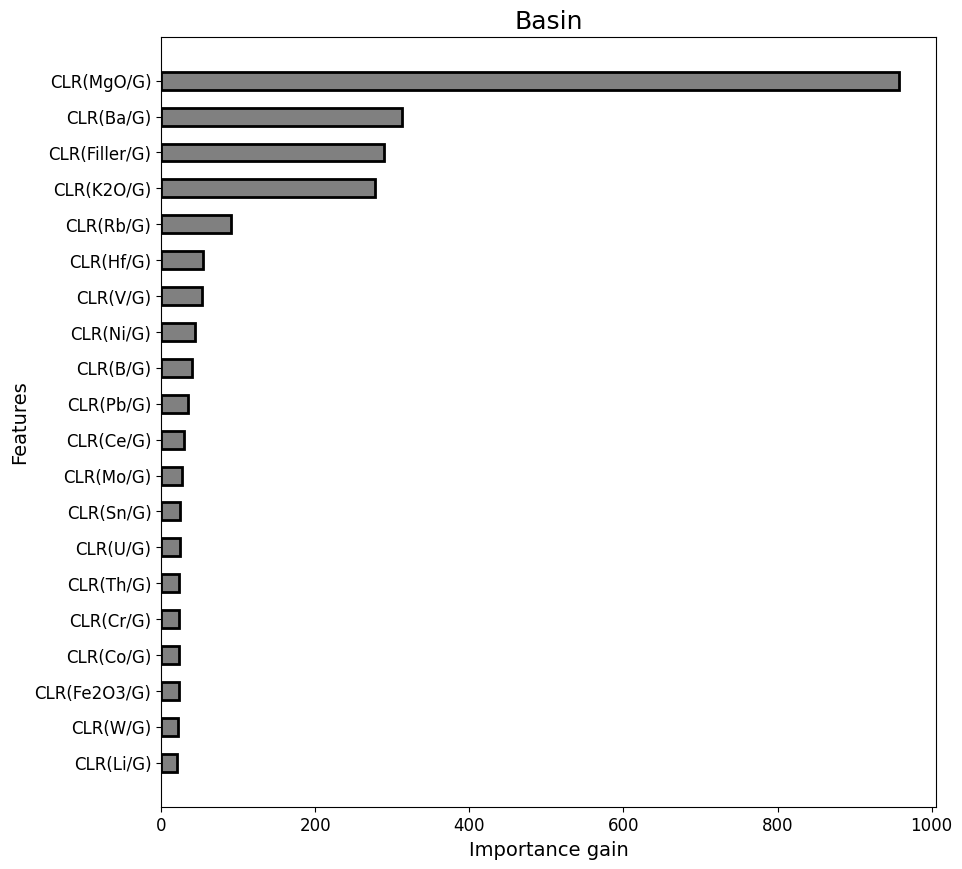

In [19]:
## Feature importance

rerun_lbgm = LGBMRegressor (**best_trials['LGBR'].params)
rerun_lbgm.fit (X_train, y_train)

# Get feature importance values
features = pd.concat([X_train], axis=1)
features.columns = features.columns.astype(str)

feature_names = features.columns
importance_values = rerun_lbgm.booster_.feature_importance(importance_type='gain')

# Sort features by importance
sorted_indices = np.argsort(importance_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Plot custom bar chart
fig, ax = plt.subplots(figsize=(10, 10))

bar_colors = 'grey'
bar_height = 0.5  

ax.barh(sorted_feature_names[:20][::-1], sorted_importance_values[:20][::-1], color=bar_colors, height=bar_height, edgecolor='black', linewidth=2)

ax.set_title('Basin', fontsize=18)
ax.set_xlabel('Importance gain', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Features_Basin_IR.png', bbox_inches = 'tight')
##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Features_Basin_IR.pdf', bbox_inches = 'tight')
plt.show()

## Prediction on the external dataset

In [26]:
## Preprocessing Getty Russell
ir_get = data_get.loc[:, '500':'2400']
ir_get = pd.DataFrame(savgol_filter(ir_get, 25, polyorder = 2, deriv = 1))

geochem_get = data_get.loc[:, 'Ag':'Filler']
geochem_clr_get = geochem_get.pyrocomp.CLR()
##geochem_ilr_get = geochem_get.pyrocomp.ILR()

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_get.columns for element2 in geochem_get.columns if element1 < element2]
geochem_pwlr_get = pd.DataFrame(index=geochem_get.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_get[element1] / geochem_get[element2])
    geochem_pwlr_get[log_ratio_column] = log_ratios

# Concatenate side by side
X_get = geochem_clr_get
X_get.columns = X_get.columns.astype(str)

y_get = (data_get['LogRLLD'])

####
pd.DataFrame(X_get)

C:\Users\serdoun1\AppData\Local\Temp\ipykernel_63404\2331006531.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  geochem_pwlr_get[log_ratio_column] = log_ratios
C:\Users\serdoun1\AppData\Local\Temp\ipykernel_63404\2331006531.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  geochem_pwlr_get[log_ratio_column] = log_ratios
C:\Users\serdoun1\AppData\Local\Temp\ipykernel_63404\2331006531.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

,CLR(Ag/G),CLR(Al2O3/G),CLR(B/G),CLR(Ba/G),CLR(Be/G),CLR(Ce/G),CLR(Co/G),CLR(Cr/G),CLR(Cu/G),CLR(Dy/G),...,CLR(Tb/G),CLR(Th/G),CLR(TiO2/G),CLR(U/G),CLR(V/G),CLR(W/G),CLR(Y/G),CLR(Yb/G),CLR(Zr/G),CLR(Filler/G)
0,-4.542189,7.746121,4.814105,0.514966,-3.086902,1.582806,-3.654886,-0.273491,-0.818219,-1.787619,...,-3.543661,0.413638,4.994367,-1.470820,-0.107977,-2.799220,-0.234271,-2.462748,2.992268,11.911245
1,-4.346202,7.396512,4.518121,0.258968,-2.919086,1.511731,-3.304748,-0.146497,-1.094536,-1.986922,...,-3.653055,0.546650,5.218310,-1.731242,-0.521190,-3.142229,-0.401389,-2.687974,3.116396,11.563711
2,-4.301451,7.527328,2.418252,0.203636,-2.963946,1.319640,-2.963946,-0.342908,-2.335338,-1.970695,...,-3.632401,0.773723,5.425413,-1.642191,-0.108914,-3.657094,-0.370559,-2.609775,3.292283,11.006647
3,-4.474280,8.001125,2.076800,0.297944,-3.183296,1.583142,-3.288657,-0.069781,-2.623680,-2.180828,...,-3.576339,0.796386,5.123176,-2.012363,-0.200143,-3.470978,-0.719443,-2.794638,2.925951,11.500561
4,-4.311398,7.576915,1.734134,0.175989,-3.289747,1.514274,-2.857964,0.111451,-2.414278,-2.139175,...,-3.646422,1.150549,5.416413,-1.933911,0.013470,-3.512890,-0.650689,-2.701960,3.155973,11.163594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,-4.926449,7.512717,2.699146,0.371868,-3.317012,1.588263,-3.540155,0.238337,-2.218399,-1.621396,...,-3.317012,0.681189,4.655455,-1.533620,-0.426640,-3.317012,0.050284,-2.441543,2.917399,12.090939
302,-4.505983,7.124726,2.634866,0.322331,-3.184227,1.387042,-3.218128,0.792335,-1.797932,-1.733394,...,-3.449930,0.569191,4.598997,-1.117364,-0.020159,-2.336929,-0.078147,-2.596440,2.673706,11.816883
303,-4.895354,8.124819,2.241243,0.402963,-3.440067,1.675929,-3.152385,0.066491,-2.459237,-1.914010,...,-3.545427,0.410081,4.802690,-1.537959,-0.194874,-2.929241,-0.290184,-2.636571,2.774541,11.533314
304,-4.962226,8.796714,2.383784,0.559235,-3.352788,1.920211,-3.458149,0.202560,-2.436497,-2.205386,...,-3.709463,-0.083219,4.451055,-1.528239,0.014508,-3.352788,-0.678640,-2.882785,2.245634,12.022377


In [27]:
## Prediction on the external dataset
rerun_lbgm.fit(X_train,y_train)

y_c = pd.DataFrame(rerun_lbgm.predict(X_get))

y_c.columns = ['Predicted_values']
print(len(y_c))
## Uncertainty prediction
rerun_lbgm = LGBMRegressor (**best_trials['LGBR'].params)

y_bootstrap_get = []
# bootstrap predictions
accuracy = []
n_iterations = 100
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples = 1000)
    rerun_lbgm.fit(X_bs,y_bs)
    # make predictions
    y_hat = rerun_lbgm.predict(X_get)
    print(i)
    y_bootstrap_get.append(y_hat)
    
y_bootstrap_get = pd.DataFrame(np.vstack(y_bootstrap_get))

##
uncertainty = pd.DataFrame(y_bootstrap_get).std(axis = 0)
mean = pd.DataFrame(y_bootstrap_get).mean(axis = 0)
y_hat = rerun_lbgm.predict(X_get)
print(len(y_hat))
upper_ci = mean + 1.96 * uncertainty
lower_ci = mean - 1.96 * uncertainty
ci_difference = upper_ci - lower_ci


306
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
306


## Mise en forme et export pour logs synthétiques

In [28]:
actual_values = data_get['LogRLLD']
predicted_values = y_c
min_ci = pd.DataFrame(lower_ci, columns = ['Lower_CI'])
max_ci = pd.DataFrame(upper_ci, columns = ['Upper_CI'])
collar = data_get.loc[:, 'HoleName':'SAMPTO']

actual_values = actual_values.reset_index(drop = True)
predicted_values = predicted_values.reset_index(drop = True)
min_ci = min_ci.reset_index(drop = True)
max_ci = max_ci.reset_index(drop = True)
collar = collar.reset_index(drop = True)

prediction_get = pd.concat ([collar, actual_values, predicted_values, min_ci, max_ci], axis = 1, sort = False)

prediction_get

,HoleName,SAMPFROM,SAMPTO,LogRLLD,Predicted_values,Lower_CI,Upper_CI
0,GRL161A,38.7,60.0,3.553217,3.710614,3.458108,3.788549
1,GRL161A,60.0,80.0,3.498721,3.375152,3.246810,3.583172
2,GRL161A,80.0,100.0,3.161494,3.154270,3.118410,3.307421
3,GRL161A,100.0,120.0,3.152553,3.075872,3.003826,3.247394
4,GRL161A,120.0,140.0,3.184414,3.065673,2.992479,3.249213
...,...,...,...,...,...,...,...
301,GRL221,140.0,150.0,3.137605,3.462626,3.338115,3.577166
302,GRL221,150.0,160.0,3.199693,3.375211,3.198710,3.488894
303,GRL221,160.0,170.0,3.042996,3.138817,3.035445,3.280129
304,GRL221,170.0,180.0,3.161647,3.274119,3.114358,3.378226


In [29]:
prediction_get.to_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Results\Prediction_GET_Sandstone.csv')